# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/Projects/pyNBA/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Data Analysis
Summarize the characteristics of the dataset.

In [34]:
feature_creation = FeatureCreation()
query_data = QueryData()
clean_data = CleanData()
helpers = Helpers()

# pull boxscore data
boxscores = query_data.query_boxscore_data()
boxscores = clean_data.select_regular_season_games(boxscores)
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [35]:
boxscores['MP'] = boxscores['SECONDSPLAYED']/60
boxscores['POSSESSIONS/MINUTE'] = boxscores['POSS']/boxscores['MP']

In [36]:
# player possessions/minute (good)
boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='POSSESSIONS/MINUTE', new_col_name='AVG_POSSESSIONS/MINUTE',
    weight_col_name='MP'
)

In [37]:
team_boxscores = boxscores.groupby(['SEASON', 'DATE', 'TEAM', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_POSSESSIONS': x['POSS'].sum(),
        'TEAM_MP': x['MP'].sum()
    })
).reset_index()
team_boxscores['TEAM_POSSESSIONS/MINUTE'] = team_boxscores['TEAM_POSSESSIONS']/team_boxscores['TEAM_MP']

opp_team_boxscores = team_boxscores.rename(
    columns={'TEAM': 'OPP_TEAM', 'OPP_TEAM': 'TEAM', 'TEAM_POSSESSIONS': 'OPP_TEAM_POSSESSIONS', 'TEAM_MP': 'OPP_TEAM_MP',
             'TEAM_POSSESSIONS/MINUTE': 'OPP_TEAM_POSSESSIONS/MINUTE'}
)

team_boxscores = team_boxscores.merge(opp_team_boxscores, on=['SEASON', 'DATE', 'TEAM', 'OPP_TEAM'], how='left')

In [38]:
# opp team possessions/minute allowed (good)

team_boxscores = feature_creation.expanding_weighted_mean(
    df=team_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_POSSESSIONS/MINUTE', new_col_name='AVG_OPP_TEAM_POSSESSIONS/MINUTE_ALLOWED',
    weight_col_name='TEAM_MP'
)

In [39]:
# possessions/minute that opp team played against

season_stats = team_boxscores.groupby(['SEASON', 'TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_POSSESSIONS(SEASON)': x['TEAM_POSSESSIONS'].mean(),
        'TEAM_MP(SEASON)': x['TEAM_MP'].mean(),
        'TEAM_POSSESSIONS_ALLOWED(SEASON)': x['OPP_TEAM_POSSESSIONS'].mean(),
        'TEAM_MP_ALLOWED(SEASON)': x['OPP_TEAM_MP'].mean()
    })
).reset_index()

season_stats['TEAM_POSSESSIONS/MINUTE(SEASON)'] = season_stats['TEAM_POSSESSIONS(SEASON)']/season_stats['TEAM_MP(SEASON)']
season_stats['TEAM_POSSESSIONS/MINUTE_ALLOWED(SEASON)'] = season_stats['TEAM_POSSESSIONS_ALLOWED(SEASON)']/season_stats['TEAM_MP_ALLOWED(SEASON)']

opp_season_stats = season_stats.rename(
    columns={'TEAM': 'OPP_TEAM', 'TEAM_POSSESSIONS(SEASON)': 'OPP_TEAM_POSSESSIONS(SEASON)',
             'TEAM_MP(SEASON)': 'OPP_TEAM_MP(SEASON)', 'TEAM_POSSESSIONS/MINUTE(SEASON)': 'OPP_TEAM_POSSESSIONS/MINUTE(SEASON)',
             'TEAM_POSSESSIONS_ALLOWED(SEASON)': 'OPP_TEAM_POSSESSIONS_ALLOWED(SEASON)', 'TEAM_MP_ALLOWED(SEASON)': 'OPP_TEAM_MP_ALLOWED(SEASON)',
             'TEAM_POSSESSIONS/MINUTE_ALLOWED(SEASON)': 'OPP_TEAM_POSSESSIONS/MINUTE_ALLOWED(SEASON)'}
)

team_boxscores = team_boxscores.merge(season_stats, on=['SEASON', 'TEAM'], how='left')
team_boxscores = team_boxscores.merge(opp_season_stats, on=['SEASON', 'OPP_TEAM'], how='left')

team_boxscores = feature_creation.expanding_weighted_mean(
    df=team_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_POSSESSIONS/MINUTE(SEASON)', new_col_name='AVG_POSSESSIONS/MINUTE(SEASON)_OPP_TEAM_P.A.',
    weight_col_name='OPP_TEAM_MP'
)

In [40]:
# possessions/minute allowed that player played against
temp = boxscores.merge(team_boxscores, on=['SEASON', 'DATE', 'TEAM', 'OPP_TEAM'], how='left')

temp = feature_creation.expanding_weighted_mean(
    df=temp, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='OPP_TEAM_POSSESSIONS/MINUTE_ALLOWED(SEASON)', new_col_name='AVG_POSSESSIONS/MINUTE_ALLOWED(SEASON)_PLAYER_P.A.',
    weight_col_name='MP'
)

In [41]:
temp = feature_creation.expanding_sum(
    df=temp, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='MP', new_col_name='SUM_MP'
)

prepared_df = temp.loc[(temp['SUM_MP'] > 10*20) & (temp['MP'] > 15)]

In [42]:
y = 'POSSESSIONS/MINUTE'
selected_features = ['AVG_POSSESSIONS/MINUTE', 'AVG_OPP_TEAM_POSSESSIONS/MINUTE_ALLOWED', 'AVG_POSSESSIONS/MINUTE(SEASON)_OPP_TEAM_P.A.', 'AVG_POSSESSIONS/MINUTE_ALLOWED(SEASON)_PLAYER_P.A.']
feature_matrix = prepared_df.dropna(subset=selected_features)

X = feature_matrix[selected_features]
Y = feature_matrix[y]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
print(model.coef_)

y_hat = X_test['AVG_POSSESSIONS/MINUTE'] + X_test['AVG_OPP_TEAM_POSSESSIONS/MINUTE_ALLOWED'] - \
    (1*X_test['AVG_POSSESSIONS/MINUTE(SEASON)_OPP_TEAM_P.A.'] + 1*X_test['AVG_POSSESSIONS/MINUTE_ALLOWED(SEASON)_PLAYER_P.A.'])/2

[ 0.76986158  0.83379813 -0.193722   -0.41388192]


In [43]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_POSSESSIONS/MINUTE']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg)), 6))

R2 (explained variance):
Model: 0.272
Baseline: 0.184

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.087471
Baseline: 0.093288

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.110765
Baseline: 0.117292


No handles with labels found to put in legend.
No handles with labels found to put in legend.


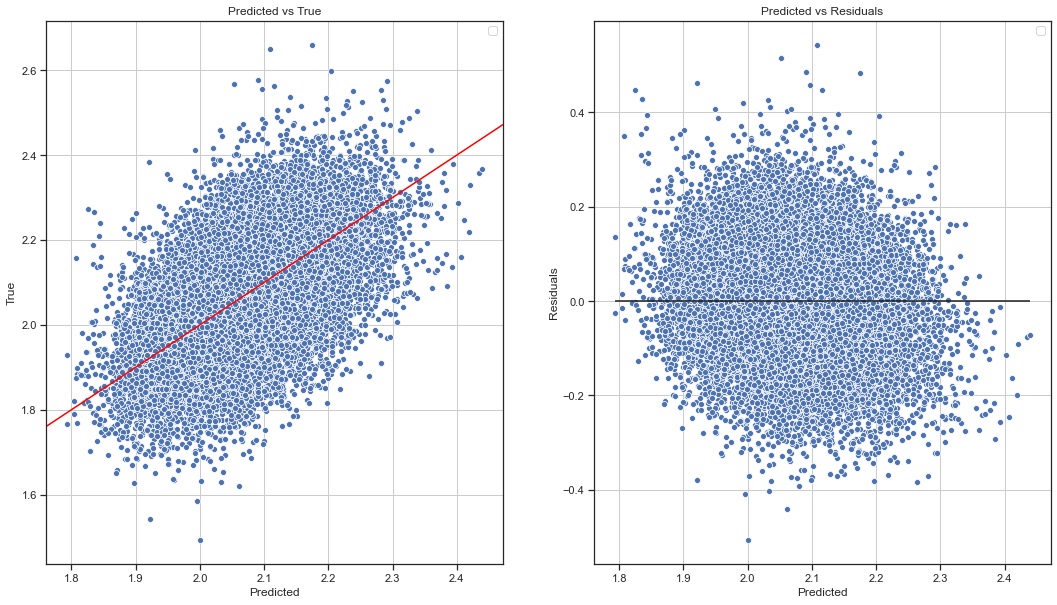

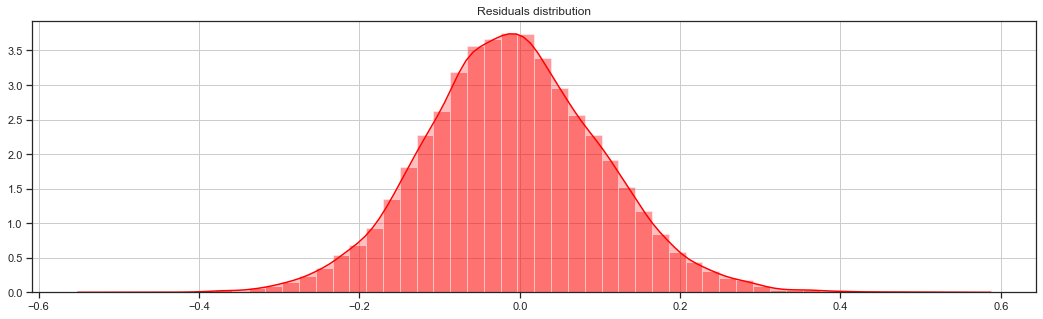

In [27]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()